In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
df = sns.load_dataset("mpg")

X_train, y_train = df[~df["horsepower"].isna()][["displacement", "acceleration"]], df[~df["horsepower"].isna()]["horsepower"]
X_pred = df[df["horsepower"].isna()][["displacement", "acceleration"]]

linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_pred)
y_pred = np.round(y_pred)
df.loc[X_pred.index, "horsepower"] = y_pred
df = pd.get_dummies(df.drop("name", axis = 1), columns = ["origin"])
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin_europe,origin_japan,origin_usa
0,18.0,8,307.0,130.0,3504,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449,10.5,70,0,0,1


In [3]:
X, y = df.drop(["mpg"], axis = 1).values, df["mpg"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

In [4]:
scaler = StandardScaler()
#scaler = MinMaxScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_val = scaler.transform(X_val)
scaled_X_test = scaler.transform(X_test)

In [5]:
%load_ext line_profiler

In [6]:
%reload_ext line_profiler

class VectorizedEvoRegressor:
    def __init__(self, n = 20, hidden_layers = False, activation = "sigmoid", random_state = None):

        self.n = n // 2 * 2
        self.best_net = -1
        self.best_result = None
        self.validation_loss_history = []
        self.training_loss_history = []
        self.mutation_sigma = 0
        self.random_state = random_state

        if activation == "sigmoid":
            self.activation_function = lambda x: 1 / (1 + np.exp(-x))
        elif activation == "relu":
            self.activation_function = lambda x: np.maximum(0, x)
        elif activation == "leaky_relu":
            self.activation_function = lambda x: np.maximum(0.1 * x, x)
        
        if hidden_layers:
            self.layers = hidden_layers + [1]
        else:
            self.layers = [1]

    def fit(self, X_train, y_train, epochs = 100, validation_data = False, verbose = 0):

        if self.random_state != None:
            np.random.seed(self.random_state)

        X_train = np.c_[np.ones(X_train.shape[0]), X_train]

        if validation_data:
            X_val, y_val = validation_data

        self.layers = [X_train.shape[1]] + self.layers

        self.y_preds = np.zeros((self.n, y_train.shape[0]))
        self.nets_loss = np.zeros(self.n)
        self.sorted_indecies = np.zeros(self.n)

        self.weights = []

        for i in range(len(self.layers) - 1):
            self.weights += [np.random.uniform(-3, 3, (self.n, self.layers[i], self.layers[i + 1]))]

        for epoch in range(epochs):
            forward_pass = X_train.T
            
            for j in range(0, len(self.layers) - 2):
                forward_pass = self.activation_function(self.weights[j].transpose(0, 2, 1) @ forward_pass)

            forward_pass = self.weights[-1].transpose(0, 2, 1) @ forward_pass
            self.y_preds = forward_pass.reshape(self.n, -1)

            self.nets_loss = np.mean(np.abs(self.y_preds - y_train), axis = 1)

            self.sorted_indecies = np.argsort(self.nets_loss)

            self.mutation_sigma = 0.1 + 5 * 1 / math.exp(epoch / ((epochs + 1) / (100 * math.log10(epochs + 1))))

            for j in range(0, len(self.layers) - 1):
                self.weights[j][self.sorted_indecies[self.n // 2::2]] = np.mean((self.weights[j][self.sorted_indecies[:self.n // 2:2]], self.weights[j][self.sorted_indecies[1:1 + self.n // 2:2]]), axis = 0) + np.random.normal(0, self.mutation_sigma, (self.n // 4, self.layers[j], self.layers[j + 1]))
                self.weights[j][self.sorted_indecies[1 + self.n // 2::2]] = np.mean((self.weights[j][self.sorted_indecies[:self.n // 2:2]], self.weights[j][self.sorted_indecies[1:1 + self.n // 2:2]]), axis = 0) + np.random.normal(0, self.mutation_sigma, (self.n // 4, self.layers[j], self.layers[j + 1]))

            if self.best_net != self.sorted_indecies[0]:
                self.best_net = self.sorted_indecies[0]
                self.training_loss_history += [self.nets_loss[self.best_net]]
                
                if validation_data:
                    self.validation_loss_history += [np.mean(np.abs(y_val - self.predict(X_val)))]
                    if verbose == 1:
                        print(f"Epoch {epoch} - loss: {self.training_loss_history[-1]} - val_loss: {self.validation_loss_history[-1]}")
                else:
                    if verbose == 1:
                        pass
                        print(f"Epoch {epoch} - loss: {self.training_loss_history[-1]}")


    def predict(self, X):
        X = np.c_[np.ones(X.shape[0]), X]

        forward_pass = X.T
        for j in range(0, len(self.layers) - 2):
            forward_pass = self.activation_function(self.weights[j][self.best_net].T @ forward_pass)

        forward_pass = self.weights[-1][self.best_net].T @ forward_pass
        return forward_pass.reshape(-1)

regressor = VectorizedEvoRegressor(n = 20, hidden_layers = [8], activation = "relu", random_state = 42)


%lprun -f regressor.fit regressor.fit(scaled_X_train, y_train, epochs = 10000, validation_data = (scaled_X_val, y_val), verbose = 1)

Epoch 0 - loss: 11.409326214872566 - val_loss: 11.485170808255846
Epoch 31 - loss: 8.837977190835439 - val_loss: 9.080621638357371
Epoch 36 - loss: 8.49043629316124 - val_loss: 6.999176852274992
Epoch 37 - loss: 8.262005957869663 - val_loss: 7.646054903453946
Epoch 39 - loss: 7.681841452952463 - val_loss: 6.240437685670597
Epoch 42 - loss: 6.751947028898243 - val_loss: 6.687845269889718
Epoch 46 - loss: 5.715512300182485 - val_loss: 5.730556055467494
Epoch 47 - loss: 5.032308596760075 - val_loss: 4.918378509156658
Epoch 56 - loss: 4.236790849675502 - val_loss: 2.91711652083728
Epoch 57 - loss: 4.163115979352726 - val_loss: 3.1895908321218367
Epoch 65 - loss: 3.6572974121895556 - val_loss: 3.54642655894349
Epoch 76 - loss: 3.385523046873998 - val_loss: 2.832014833962699
Epoch 78 - loss: 3.214297259032253 - val_loss: 3.205547474073492
Epoch 89 - loss: 3.209054762151541 - val_loss: 2.77318690686388
Epoch 95 - loss: 2.8717510180697277 - val_loss: 2.032182909421379
Epoch 101 - loss: 2.80127

Timer unit: 1e-06 s

Total time: 1.91834 s
File: /var/folders/xz/f2gwbn5n3vs4pz044n49z3cw0000gn/T/ipykernel_64896/1278720871.py
Function: fit at line 26

Line #      Hits         Time  Per Hit   % Time  Line Contents
    26                                               def fit(self, X_train, y_train, epochs = 100, validation_data = False, verbose = 0):
    27                                           
    28         1          2.0      2.0      0.0          if self.random_state != None:
    29         1         13.0     13.0      0.0              np.random.seed(self.random_state)
    30                                           
    31         1         98.0     98.0      0.0          X_train = np.c_[np.ones(X_train.shape[0]), X_train]
    32                                           
    33         1          1.0      1.0      0.0          if validation_data:
    34         1          0.0      0.0      0.0              X_val, y_val = validation_data
    35                             

In [472]:
int(round(17 / 8) * 8)

16

In [473]:
%reload_ext line_profiler

class VectorizedEvoRegressor2:
    def __init__(self, n = 20, hidden_layers = False, activation = "relu", n_parts = 4, lr_decay = 20, random_state = None):

        self.n = n // 2 * 2
        self.validation_loss_history = []
        self.training_loss_history = []
        self.random_state = random_state
        self.activation = activation
        self.number_of_layers = 0
        self.lr_decay = lr_decay
        
        if hidden_layers:
            self.layers = hidden_layers + [1]
        else:
            self.layers = [1]

        if n_parts == 2 or n_parts == 4:
            self.n_parts = int(n_parts)
        else:
            self.n_parts = 4

    def fit(self, X_train, y_train, epochs = 100, validation_data = False, verbose = 0, lr_sigma = "old"):

        if self.random_state != None:
            np.random.seed(self.random_state)

        if validation_data:
            X_val, y_val = validation_data

        if self.activation == "sigmoid":
            activation_function = lambda x: 1 / (1 + np.exp(-x))
        elif self.activation == "leaky_relu":
            activation_function = lambda x: np.maximum(0.1 * x, x)
        else:
            activation_function = lambda x: np.maximum(0, x)
            #activation_function = lambda x: (abs(x) + x) / 2
            #def activation_function(x):
            #    x[x < 0] = 0
            #activation_function = lambda x: np.maximum(x, 0, x)

        X_train = np.c_[np.ones(X_train.shape[0]), X_train]

        n = self.n
        n_parts = self.n_parts
        n_div_parts = n // n_parts

        lr_decay = self.lr_decay

        layers = [X_train.shape[1]] + self.layers
        number_of_layers_minus_one = len(layers) - 1
        y_preds = np.zeros((n, y_train.shape[0]))
        nets_loss = np.zeros(n)
        sorted_indecies = np.arange(-(n // 2), n, 1)
        #sorted_indecies = np.zeros(n)
        best_net_index = -1
        weights = []


        for i in range(number_of_layers_minus_one):
            #weights += [np.random.uniform(-3, 3, (n, layers[i], layers[i + 1]))]
            weights += [np.random.normal(0, 2, (n, layers[i], layers[i + 1]))]

        for epoch in range(epochs):
            forward_pass = X_train.T
            
            for j in range(number_of_layers_minus_one - 1):
                forward_pass = activation_function(weights[j][sorted_indecies[n_div_parts:]].transpose(0, 2, 1) @ forward_pass)
                #forward_pass = activation_function(weights[j].transpose(0, 2, 1) @ forward_pass)

            forward_pass = weights[-1][sorted_indecies[n_div_parts:]].transpose(0, 2, 1) @ forward_pass
            #forward_pass = weights[-1].transpose(0, 2, 1) @ forward_pass
            
            y_preds[sorted_indecies[n_div_parts:]] = forward_pass.reshape(*forward_pass.shape[::2])
            #y_preds = forward_pass.reshape(n, -1)

            nets_loss[sorted_indecies[n_div_parts:]] = np.mean(np.abs(y_preds[sorted_indecies[n_div_parts:]] - y_train), axis = 1)

            sorted_indecies = np.argsort(nets_loss)

            #mutation_sigma = 0.1 + 5 * 1 / math.exp(epoch / ((epochs + 1) / (100 * math.log10(epochs + 1))))
            if lr_sigma == "old":
                mutation_sigma = lr_min + 1 * 1 / math.exp(epoch / ((epochs + 1) / (lr_decay * math.log10(epochs + 1))))
            if lr_sigma == "new":
                mutation_sigma = math.exp(-(epoch + 1) * (math.log10((epochs + 1)) / ((epochs + 1) / 10))) + 0.1 * math.exp(-(epoch + 1) * (1 / (epochs + 1)))
            if lr_sigma == "mix":
                mutation_sigma = math.exp(-epoch / (epochs / (lr_decay * math.log10(epochs + 1)))) + 0.02 * math.exp(-(epoch + 1) * (1 / (epochs + 1))) - 0.005

            for j in range(number_of_layers_minus_one):
                #print(weights[j][sorted_indecies[0 + n // 4::4]].shape, weights[j][sorted_indecies[:n // 4:2]].shape, weights[j][sorted_indecies[1:1 + n // 4:2]].shape)
                #print(sorted_indecies)
                #print(sorted_indecies[0 + n // 4::4], sorted_indecies[:n // 4:2], sorted_indecies[1:1 + n // 4:2])
                
                if n_parts == 2:
                    weights[j][sorted_indecies[n_div_parts::2]] = (weights[j][sorted_indecies[:n_div_parts:2]] + weights[j][sorted_indecies[1:1 + n_div_parts:2]]) / 2 + np.random.normal(0, mutation_sigma, (n_div_parts // 2, layers[j], layers[j + 1]))
                    weights[j][sorted_indecies[1 + n_div_parts::2]] = (weights[j][sorted_indecies[:n_div_parts:2]] + weights[j][sorted_indecies[1:1 + n_div_parts:2]]) / 2 + np.random.normal(0, mutation_sigma, (n_div_parts // 2, layers[j], layers[j + 1]))
                if n_parts == 4:
                    weights[j][sorted_indecies[0 + n_div_parts::6]] = (weights[j][sorted_indecies[0: n_div_parts: 2]] + weights[j][sorted_indecies[1: n_div_parts: 2]]) / 2 + np.random.normal(0, mutation_sigma, (n_div_parts // 2, layers[j], layers[j + 1]))
                    weights[j][sorted_indecies[1 + n_div_parts::6]] = (weights[j][sorted_indecies[0: n_div_parts: 2]] + weights[j][sorted_indecies[1: n_div_parts: 2]]) / 2 + np.random.normal(0, mutation_sigma, (n_div_parts // 2, layers[j], layers[j + 1]))
                    weights[j][sorted_indecies[2 + n_div_parts::6]] = (weights[j][sorted_indecies[0: n_div_parts: 2]] + weights[j][sorted_indecies[1: n_div_parts: 2]]) / 2 + np.random.normal(0, mutation_sigma, (n_div_parts // 2, layers[j], layers[j + 1]))
                    weights[j][sorted_indecies[3 + n_div_parts::6]] = (weights[j][sorted_indecies[0: n_div_parts: 2]] + weights[j][sorted_indecies[1: n_div_parts: 2]]) / 2 + np.random.normal(0, mutation_sigma, (n_div_parts // 2, layers[j], layers[j + 1]))
                    weights[j][sorted_indecies[4 + n_div_parts::6]] = (weights[j][sorted_indecies[0: n_div_parts: 2]] + weights[j][sorted_indecies[1: n_div_parts: 2]]) / 2 + np.random.normal(0, mutation_sigma, (n_div_parts // 2, layers[j], layers[j + 1]))
                    weights[j][sorted_indecies[5 + n_div_parts::6]] = (weights[j][sorted_indecies[0: n_div_parts: 2]] + weights[j][sorted_indecies[1: n_div_parts: 2]]) / 2 + np.random.normal(0, mutation_sigma, (n_div_parts // 2, layers[j], layers[j + 1]))

            if best_net_index != sorted_indecies[0] or 1 == 1:
                best_net_index = sorted_indecies[0]
            
                self.training_loss_history += [nets_loss[best_net_index]]
                

                self.best_net_weights = []
                for j in range(number_of_layers_minus_one):
                    self.best_net_weights += [weights[j][best_net_index]]
                
                if validation_data:
                    self.validation_loss_history += [np.mean(np.abs(y_val - self.predict(X_val)))]
                    if verbose == 1:
                        print(f"Epoch {epoch} - loss: {self.training_loss_history[-1]} - val_loss: {self.validation_loss_history[-1]}")
                else:
                    if verbose == 1:
                        pass
                        print(f"Epoch {epoch} - loss: {self.training_loss_history[-1]}")
            
        return self.training_loss_history


    def predict(self, X):
        X = np.c_[np.ones(X.shape[0]), X]

        if self.activation == "sigmoid":
            activation_function = lambda x: 1 / (1 + np.exp(-x))
        elif self.activation == "leaky_relu":
            activation_function = lambda x: np.maximum(0.1 * x, x)
        else:
            activation_function = lambda x: np.maximum(0, x)

        forward_pass = X.T
        for j in range(len(self.best_net_weights) - 1):
            forward_pass = activation_function(self.best_net_weights[j].T @ forward_pass)

        forward_pass = self.best_net_weights[-1].T @ forward_pass
        return forward_pass.ravel()

regressor = VectorizedEvoRegressor2(n = 480 // 2, hidden_layers = [16], activation = "relu", random_state = 42, n_parts = 4, lr_decay = 20)

%lprun -f regressor.fit regressor.fit(scaled_X_train, y_train, epochs = 10000, validation_data = (scaled_X_val, y_val), verbose = 1, lr_sigma = "mix")
#regressor.fit(scaled_X_train, y_train, epochs = 100, validation_data = (scaled_X_val, y_val), verbose = 1, div = 2)

Epoch 0 - loss: 7.737057559160331 - val_loss: 8.01487563511419
Epoch 1 - loss: 7.510331828695556 - val_loss: 8.968397931066926
Epoch 2 - loss: 6.5947106040460755 - val_loss: 7.0458890972361505
Epoch 3 - loss: 6.5947106040460755 - val_loss: 7.0458890972361505
Epoch 4 - loss: 5.829510974233065 - val_loss: 4.908348079817188
Epoch 5 - loss: 5.281573644652448 - val_loss: 4.607294742401278
Epoch 6 - loss: 5.281573644652448 - val_loss: 4.607294742401278
Epoch 7 - loss: 5.281573644652448 - val_loss: 4.607294742401278
Epoch 8 - loss: 5.281573644652448 - val_loss: 4.607294742401278
Epoch 9 - loss: 5.281573644652448 - val_loss: 4.607294742401278
Epoch 10 - loss: 5.112338479928962 - val_loss: 4.755319630232976
Epoch 11 - loss: 4.900885896319837 - val_loss: 5.699607911615603
Epoch 12 - loss: 4.900885896319837 - val_loss: 5.699607911615603
Epoch 13 - loss: 4.900885896319837 - val_loss: 5.699607911615603
Epoch 14 - loss: 4.900885896319837 - val_loss: 5.699607911615603
Epoch 15 - loss: 4.9008858963198

Timer unit: 1e-06 s

Total time: 18.2073 s
File: /var/folders/xz/f2gwbn5n3vs4pz044n49z3cw0000gn/T/ipykernel_64896/4277616147.py
Function: fit at line 24

Line #      Hits         Time  Per Hit   % Time  Line Contents
    24                                               def fit(self, X_train, y_train, epochs = 100, validation_data = False, verbose = 0, lr_sigma = "old"):
    25                                           
    26         1          5.0      5.0      0.0          if self.random_state != None:
    27         1        130.0    130.0      0.0              np.random.seed(self.random_state)
    28                                           
    29         1          1.0      1.0      0.0          if validation_data:
    30         1          0.0      0.0      0.0              X_val, y_val = validation_data
    31                                           
    32         1          1.0      1.0      0.0          if self.activation == "sigmoid":
    33                              

1.550102315157615
1.4803432604007358


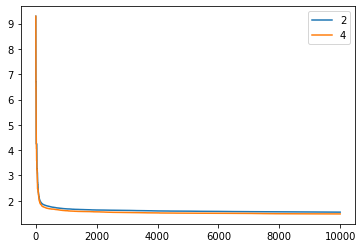

In [445]:
training_loss_history = []
learning_rate_decay = [10, 20, 60, 100, 200]
lr_mins = [0.2, 0.1, 0.05]
lr_sigmas = ["old", "new", "mix"]
divs = [2, 4]
params = divs

for param in params:
    regressor = VectorizedEvoRegressor2(n = 96, hidden_layers = [16], activation = "relu", random_state = 42)
    training_loss_history += [regressor.fit(scaled_X_train, y_train, epochs = 10000, validation_data = (scaled_X_val, y_val), verbose = 0, div = param, lr_decay = 20, lr_min = 0.1, lr_sigma = "mix")]
    print(regressor.training_loss_history[-1])

fig, ax = plt.subplots(1, 1)
for training_loss, param in zip(training_loss_history, params):
    ax.plot(training_loss, label = param)

plt.legend()
plt.show()

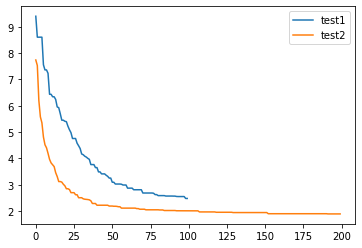

In [211]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.plot(regressor.training_loss_history, label = "test1")
#ax.plot(regressor.validation_loss_history, )
ax.plot(regressor2.training_loss_history, label = "test2")
#ax.plot(regressor2.validation_loss_history)
plt.legend()
plt.show()


0.002365


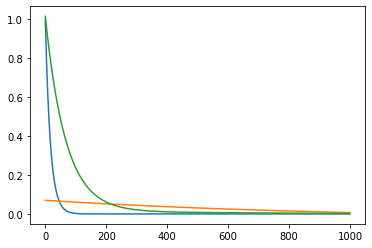

In [441]:
epochs = 1000
y1 = lambda epoch: 1 / math.exp(epoch / ((epochs + 1) / (20 * math.log10(epochs + 1))))
y2 = lambda epoch: 0.1 * math.exp(-(epoch + 1) * (1 / (epochs + 1))) - 0.03
y3 = lambda epoch: math.exp(-epoch / (epochs / (5 * math.log10(epochs + 1)))) + 0.02 * math.exp(-(epoch + 1) * (1 / (epochs + 1))) - 0.005

a1 = list(range(epochs))
a1 = [y1(x) for x in a1]
a2 = list(range(epochs))
a2 = [y2(x) for x in a2]
a3 = list(range(epochs))
a3 = [y3(x) for x in a3]

fig, ax = plt.subplots(1, 1)
print(f"{a3[-1]:f}")
ax.plot(a1)
ax.plot(a2)
ax.plot(a3)

0.000000


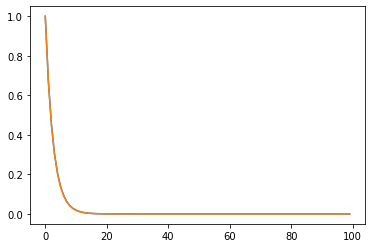

In [416]:
epochs = 100
y = lambda epoch:  1 / math.exp(epoch / ((epochs + 1) / (20 * math.log10(epochs + 1))))
y1 = lambda epoch:  math.exp(-epoch / (epochs / (20 * math.log10(epochs + 1))))

a = list(range(epochs))
a = [y(x) for x in a]
a1 = list(range(epochs))
a1 = [y1(x) for x in a1]

fig, ax = plt.subplots(1, 1)
print(f"{a[-1]:f}")
#print(f"{math.log10(max // 10) / 10:f}")
ax.plot(a)
ax.plot(a1)

In [203]:
b

In [157]:

print(regressor.training_loss_history.__len__())
print(regressor.validation_loss_history.__len__())
print(regressor2.training_loss_history.__len__())
print(regressor2.validation_loss_history.__len__())

2000
2000
1000
1000


In [208]:
hej, = ["hej"]

hej

'hej'

In [534]:
(-0.018 * 10 * 0.1)

-0.018

First_1: 1.103005
Last_1: 0.040788


[]

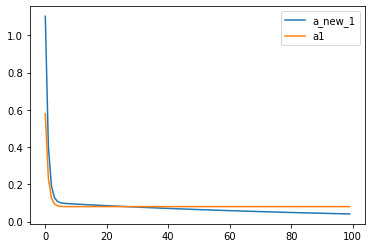

In [548]:
epochs = 100
lr_target = 0.04
lr_inital_descent = 60
lr_final_descent = 0.1

mutation_sigma1 = lambda epoch: 0.08 + 0.5 * 1 / math.exp(epoch / ((epochs + 1) / (60 * math.log10(epochs + 1))))
#mutation_sigma2 = lambda epoch: math.exp(-epoch / (epochs / (20 * math.log10(epochs + 1)))) + 0.08 * math.exp(-(epoch + 1) * (1 / (epochs + 1))) + 0.05

mutation_sigma_new_1 = lambda epoch: math.exp(-epoch / (epochs / (lr_inital_descent * math.log10(epochs + 1)))) + lr_final_descent * math.exp(-(epoch + 1) * (1 / (epochs))) + lr_target + (-0.036 * 10 * lr_final_descent)
#mutation_sigma_new_2 = lambda epoch: lr_final_descent * math.exp(-(epoch + 1) * (1 / (epochs))) + lr_target + (-0.036 * 10 * lr_final_descent)

a1 = list(range(epochs))
a1 = [mutation_sigma1(x) for x in a1]
#a2 = list(range(epochs))
#a2 = [mutation_sigma2(x) for x in a2]
a_new_1 = list(range(epochs))
a_new_1 = [mutation_sigma_new_1(x) for x in a_new_1]

#a_new_2 = list(range(epochs))
#a_new_2 = [mutation_sigma_new_2(x) for x in a_new_2]

fig, ax = plt.subplots(1, 1)
print(f"First_1: {a_new_1[0]:f}")
print(f"Last_1: {a_new_1[-1]:f}")
#print(f"First_2: {a_new_2[0]:f}")
#print(f"Last_2: {a_new_2[-1]:f}")
ax.plot(a_new_1, label = "a_new_1")
ax.plot(a1, label = "a1")
#ax.plot(a_new_2, label = "a_new_2")
ax.legend()
plt.plot()